In [1]:
import sys
import torch
from numpy import unravel_index as unravel
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import heapq
import math

In [2]:
action_dict = {'a': torch.tensor([0., -1.]), 'd': torch.tensor([0., 1.]), 'w': torch.tensor([-1., 0.]), 's': torch.tensor([1., 0.])}

def do(snake: torch.Tensor, action):
    reward = 0
    positions = snake.flatten().topk(2)[1]
    [pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.shape)) for x in positions]
    #print('direction', (pos_cur - pos_prev)) # Направление движения
    pos_next = (pos_cur + action) % torch.Tensor([snake.shape]).squeeze(0) 
    
    pos_cur = pos_cur.int()
    pos_next = pos_next.int()
    
    # Проверка на столкновение
    if (snake[tuple(pos_next)] > 0).any():
        reward = -100
        return reward,(snake[tuple(pos_cur)] - 2).item()  # Возвращаем счёт (длина змейки минус 2)
    
    # Кушаем яблоко
    if snake[tuple(pos_next)] == -1:
        pos_food = (snake == 0).flatten().to(torch.float).multinomial(1)[0] # Генерируем позицию яблока
        snake[unravel(pos_food, snake.shape)] = -1 # Добавляем яблоко в игру
        reward= 10
        
    else: # Двигаемся в пустую клетку
        snake[snake > 0] -= 1  # Устанавливаем все значения в теле змеи равными 1

    snake[tuple(pos_next)] = snake[tuple(pos_cur)] + 1 # перемещаем голову
    return reward, (snake[tuple(pos_cur)] - 2).item()


In [4]:
class Neuro_BigBoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3, 32, kernel_size=(3,3), padding = 1)
        self.conv1=nn.Conv2d(32, 64, kernel_size=(3,3), padding = 1)
        self.fl = nn.Flatten()
        self.fc1=nn.Linear(64*32*32, 32)
        self.fc2=nn.Linear(32,4)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x= F.relu(self.conv2(x))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = self.fc1(x)

In [79]:
class Champion():
    def __init__(self):
        super().__init__()
        self.n_games = 0
        self.model = Neuro_BigBoss().cuda()
        self.eps = 0

    def get_state(self, snake):
        head = (snake.topk(1)[0].argmax(),snake.topk(1)[1][snake.topk(1)[0].argmax()])
        head[1]=head[1][0]
        head_cords = [head[0].item(),head[1]]
        up_point = [head_cords[0]-1,head_cords[1]]
        down_point = [head_cords[0]+1,head_cords[1]]
        left_point = [head_cords[0],head_cords[1]-1]
        right_point = [head_cords[0],head_cords[1]+1]
        if up_point[0]==-1:
            up_point[0]=31
        if down_point[0]==32:
            down_point[0]=0
        if left_point[1]==-1:
            left_point[1]=31
        if right_point[1]==32:
            right_point[1]=0
        

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


In [4]:
class Node:
    def __init__(self, x, y):
        self.x = x  # Координата x узла на карте
        self.y = y  # Координата y узла на карте
        self.g = 0  # Расстояние от начального узла до текущего узла
        self.h = 0  # Примерное расстояние от текущего узла до конечного узла
        self.f = 0  # Сумма g и h
        self.parent = None  # Родительский узел, используется для восстановления пути

    # Переопределяем оператор сравнения для сравнения узлов
    def __lt__(self, other):
        return self.f < other.f

    # Переопределяем оператор равенства для сравнения узлов
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))

# Определяем функцию для нахождения пути с помощью алгоритма A*
def astar(start, end, obstacles):

    # Создаем начальный и конечный узлы
    start_node = Node(start[0], start[1])
    end_node = Node(end[0], end[1])

    # Инициализируем очередь с приоритетами
    open_list = []
    heapq.heappush(open_list, start_node)

    # Инициализируем множество посещенных узлов
    closed_set = set()

    # Пока очередь с приоритетами не пуста
    while open_list:
        # Извлекаем узел с наименьшей оценкой f
        current_node = heapq.heappop(open_list)
        # Если текущий узел является конечным
        if current_node == end_node:
            # Восстанавливаем путь от конечного узла до начального
            path = []
            while current_node.parent is not None:
                path.append((current_node.x, current_node.y))
                current_node = current_node.parent
            return path[-1]

        # Добавляем текущий узел в множество посещенных узлов
        closed_set.add(current_node)

        # Получаем соседние узлы
        neighbors = []
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # Игнорируем текущий узел
                if not ((dx == -1 and dy == 0) or (dx == 0 and dy == 1) or (dx == 1 and dy == 0) or (dx == 0 and dy == -1)):
                    continue
                # Вычисляем координаты соседнего узла
                x = current_node.x + dx
                y = current_node.y + dy
                # Игнорируем узлы за пределами карты
                if x < 0 :
                    x=len(obstacles)-1
                if x>=len(obstacles):
                    x=0
                if y<0:
                    y=len(obstacles)-1
                if y>=len(obstacles):
                    y=0
                # Игнорируем препятствия
                if obstacles[x][y] == 1:
                    continue
                # Создаем новый узел и добавляем его в список соседей
                neighbor = Node(x, y)
                neighbors.append(neighbor)

        # Для каждого соседнего узла
        for neighbor in neighbors:
            # Если соседний узел уже был посещен, пропускаем его
            if neighbor in closed_set:
                continue

            # Вычисляем расстояние от начального узла до соседнего узла
            new_g = current_node.g + 1

            # Если соседний узел уже находится в очереди с приоритетами
            if nfo := next((n for n in open_list if n == neighbor), None):
                # Если новое расстояние до соседнего узла меньше, чем старое, обновляем значения g, h и f
                if new_g < nfo.g:
                    nfo.g = new_g
                    nfo.h = math.sqrt((end_node.x - nfo.x) ** 2 + (end_node.y - nfo.y) ** 2)
                    nfo.f = nfo.g + nfo.h
                    nfo.parent = current_node
                    # Обновляем приоритет соседнего узла в очереди с приоритетами
                    heapq.heapify(open_list)
            else:
                # Иначе добавляем соседний узел в очередь с приоритетами и вычисляем значения g, h и f
                neighbor.g = new_g
                neighbor.h = math.sqrt((end_node.x - neighbor.x) ** 2 + (end_node.y - neighbor.y) ** 2)
                neighbor.f = neighbor.g + neighbor.h
                neighbor.parent = current_node
                heapq.heappush(open_list, neighbor)

    # Если конечный узел недостижим, возвращаем None
    return None


In [115]:
class Snake:
    def __init__(self):
        self.field = torch.zeros((32, 32), dtype=torch.int)
        self.field[0, :3] = torch.Tensor([1, 2, -1]) # [хвост, голова, яблоко]
        self.dirrection = [0,1]
        self.head_cords = [0,1]
        self.apple_cords = [0,2]
        self.neighbours = [[31,1],[0,0],[0,2],[1,1]]
        self.collision = [False, True, False, False]
    
    def set_dirrection(self, dir):
        self.dirrection = dir
    
    def set_head_cords(self,head):
        self.head_cords = head
    
    def set_apple_cords(self,apple):
        self.apple_cords = apple
    
    def set_neighbours(self):
        counter = 0
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                # Игнорируем текущий узел
                if not ((dx == -1 and dy == 0) or (dx == 0 and dy == 1) or (dx == 1 and dy == 0) or (dx == 0 and dy == -1)):
                    continue
                x = self.head_cords[0] + dx
                y = self.head_cords[1] + dy

                if x < 0 :
                    x=31
                if x>=32:
                    x=0
                if y<0:
                    y=31
                if y>=32:
                    y=0

                self.neighbours[counter] = [x,y]
                if self.field[x][y] > 0:
                    self.collision[counter] = True
                else:
                    self.collision[counter] = False
                counter+=1

    def get_state(self):
        return [[self.dirrection],[self.head_cords], [self.apple_cords],self.neighbours,self.collision]

In [116]:
snake = Snake()
reward = 0
while True:
    a = torch.zeros(snake.field.shape)
    a[snake.field>0]=1
    a[snake.field==snake.field.max()]=2
    a[snake.field<0]=-1
    head = [snake.field.topk(1)[0].argmax().numpy(),snake.field.topk(1)[1][snake.field.topk(1)[0].argmax()].numpy()]
    apple = [(snake.field.argmin()/32).int().item(),
        (snake.field.argmin()%32).item()]
    head[1]=head[1][0]
    head_cords = [head[0].item(),head[1]]
    snake.set_apple_cords(apple)
    snake.set_head_cords(head_cords)
    snake.set_neighbours()
    if reward == -100:
        break
    path = astar( head_cords, apple, a)
    if path == None:
        break
    cords = np.array(path)
    # print(cords, np.array(head_cords))
    cords-=np.array(head_cords)
    if cords[0]==-31:
        cords[0]=1
    if cords[0]==31:
        cords[0]=-1
    if cords[1]==-31:
        cords[1]=1
    if cords[1]==31:
        cords[1]=-1
    # fig, ax = plt.subplots(1, 1)
    # img = ax.imshow(a)
    action = {'val': 1}
    n = 0
    score = None
    # img.set_data(a)
    snake.set_dirrection(cords)
    reward, score = do(snake.field, cords)
    n += 1
    # print(reward, score, cords)
print(score)

83


[[array([ 0, -1], dtype=int64)], [[26, 10]], [[17, 1]], [[25, 10], [26, 9], [26, 11], [27, 10]], [True, False, True, False]]


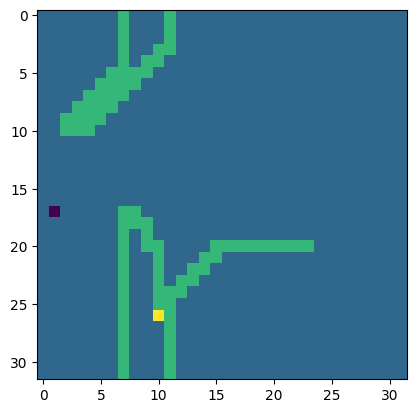

In [117]:
fig, ax = plt.subplots(1, 1)
a = torch.zeros(snake.field.shape)
positions = snake.field.flatten().topk(2)[1]
[pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.field.shape)) for x in positions]
a[snake.field>0]=1
a[snake.field==snake.field.max()]=2
a[snake.field<0]=-1
# print(a)
img = ax.imshow(a)
action = {'val': 1}
# print(a)
n = 0
score = None

while n<1:
    img.set_data(a)
    # reward, score = do(snake.field, action_dict['a'])
    n += 1
# print(reward, score)
# print(score)
state = snake.get_state()
print(state)